In [1]:
# Importing the relevant packages
import tensorflow as tf
import tensorflow_datasets as tfds

## Downloading and preprocessing the data

In [2]:
# Before continuing with our model and training, our first job is to preprocess the dataset
# This is a very important step in all of machine learning

# The MNIST dataset is, in general, highly processed already - after all its 28x28 grayscale images of clearly visible digits
# Thus, our preprocessing will be limited to scaling the pixel values, shuffling the data and creating a validation set

# NOTE: When finally deploying a model in practice, it might be a good idea to include the prerpocessing as initial layers
# In that way, the users could just plug the data (images) directly, instead of being required to resize/rescale it before

In [3]:
# Defining some constants/hyperparameters
BUFFER_SIZE = 70_000 # for reshuffling
BATCH_SIZE = 128
NUM_EPOCHS = 20

In [109]:
# Downloading the MNIST dataset

# When 'with_info' is set to True, tfds.load() returns two variables: 
# - the dataset (including the train and test sets) 
# - meta info regarding the dataset itself

mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)

display(mnist_dataset)
display(mnist_info)

{'train': <_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 'test': <_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/Users/jgibb/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
   

In [ ]:
# Extracting the train and test datasets
mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']

mnist_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [6]:
# Creating a function to scale our image data (it is recommended to scale the pixel values in the range [0,1] )
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.

    return image, label

In [ ]:
# Scaling the data
train_and_validation_data = mnist_train.map(scale)
test_data = mnist_test.map(scale)

train_and_validation_data

<_MapDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Defining the size of the validation set
num_validation_samples = 0.1 * mnist_info.splits['train'].num_examples
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

num_validation_samples

<tf.Tensor: shape=(), dtype=int64, numpy=6000>

In [ ]:
# Defining the size of the test set
num_test_samples = mnist_info.splits['test'].num_examples
num_test_samples = tf.cast(num_test_samples, tf.int64)

num_test_samples

<tf.Tensor: shape=(), dtype=int64, numpy=10000>

In [ ]:
# Reshuffling the dataset
train_and_validation_data = train_and_validation_data.shuffle(BUFFER_SIZE)

train_and_validation_data

<_ShuffleDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Splitting the dataset into training + validation
train_data = train_and_validation_data.skip(num_validation_samples)
validation_data = train_and_validation_data.take(num_validation_samples)

train_data

<_SkipDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [110]:
# Batching the data
# NOTE: For proper functioning of the model, we need to create one big batch for the validation and test sets
train_data = train_data.batch(BATCH_SIZE)
validation_data = validation_data.batch(num_validation_samples) 
test_data = test_data.batch(num_test_samples)

train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Creating the model and training it

In [13]:
# Now that we have preprocessed the dataset, we can define our CNN and train it

In [ ]:
# Outlining the model/architecture of our CNN
# CONV -> MAXPOOL -> CONV -> MAXPOOL -> FLATTEN -> DENSE
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(50, 5, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
    # (2,2) is the default pool size so we could have just used MaxPooling2D() with no explicit arguments
    tf.keras.layers.Conv2D(50, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10) # You can apply softmax activation here, see below for comentary
])

In [71]:
# A brief summary of the model and parameters
model.summary(line_length = 75)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                   ┃ Output Shape            ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)             │ (None, 24, 24, 50)      │        1,300 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ max_pooling2d_10               │ (None, 12, 12, 50)      │            0 │
│ (MaxPooling2D)                 │                         │              │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ conv2d_11 (Conv2D)             │ (None, 10, 10, 50)      │       22,550 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ max_pooling2d_11               │ (None, 5, 5, 50)        │            0 │
│ (MaxPooling2D)                 │                         │              │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ flatten_5 (Flatten)            │ (None, 1250)            │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ dense_5 (Dense)                │ (None, 10)              │       12,510 │
└────────────────────────────────┴─────────────────────────┴──────────────┘

 Total params: 36,360 (142.03 KB)

 Trainable params: 36,360 (142.03 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
# Defining the loss function

# In general, our model needs to output probabilities of each class, 
# which can be achieved with a softmax activation in the last dense layer

# However, when using the softmax activation, the loss can rarely be unstable

# Thus, instead of incorporating the softmax into the model itself,
# we use a loss calculation that automatically corrects for the missing softmax

# That is the reason for 'from_logits=True'
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
# Compiling the model with Adam optimizer and the categorical crossentropy as a loss function
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [74]:
# Defining early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'auto',    
    min_delta = 0,
    patience = 2,
    verbose = 0, 
    restore_best_weights = True
)

In [ ]:
# Logging the training process data to use later in tensorboard
log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
# Train the network
model.fit(
    train_data, 
    epochs = NUM_EPOCHS, 
    callbacks = [tensorboard_callback, early_stopping], 
    validation_data = validation_data,
    verbose = 1
)

Epoch 1/20


2025-03-13 17:26:27.978086: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8276 - loss: 0.6133 - val_accuracy: 0.9747 - val_loss: 0.0898
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9770 - loss: 0.0758 - val_accuracy: 0.9867 - val_loss: 0.0477
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9841 - loss: 0.0515 - val_accuracy: 0.9892 - val_loss: 0.0374
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9877 - loss: 0.0402 - val_accuracy: 0.9893 - val_loss: 0.0343
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9889 - loss: 0.0377 - val_accuracy: 0.9917 - val_loss: 0.0280
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9906 - loss: 0.0302 - val_accuracy: 0.9933 - val_loss: 0.0214
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9923 - loss: 0.0262 - val_accuracy: 0.9925 - val_loss: 0.0223
Epoch 8/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9933 - loss: 0.0232 - val_accuracy: 0.993

## Testing our model

In [76]:
# Testing our model
test_loss, test_accuracy = model.evaluate(test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.9913 - loss: 0.0276


In [77]:
# Printing the test results
print('Test loss: {0:.4f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

Test loss: 0.0276. Test accuracy: 99.13%


### Plotting images and the results

In [78]:
import matplotlib.pyplot as plt
import numpy as np

In [112]:
# Split the test_data into 2 arrays, containing the images and the corresponding labels
for images, labels in test_data.take(1):
    images_test = images.numpy()
    labels_test = labels.numpy()

# Reshape the images into 28x28 form, suitable for matplotlib (original dimensions: 28x28x1)
images_plot = np.reshape(images_test, (10000,28,28))

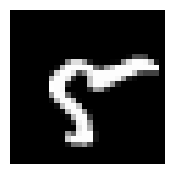

Label: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<BarContainer object of 10 artists>

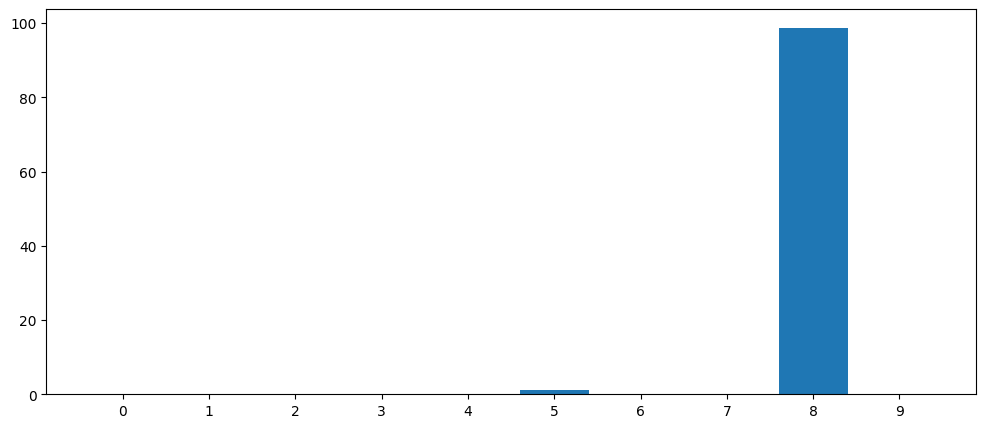

In [113]:
# The image to be displayed and tested
i = 502

# Plot the image
plt.figure(figsize=(2, 2))
plt.axis('off')
plt.imshow(images_plot[i-1], cmap="gray", aspect='auto')
plt.show()

# Print the correct label for the image
print("Label: {}".format(labels_test[i-1]))

# Obtain the model's predictions (logits)
predictions = model.predict(images_test[i-1:i])

# Convert those predictions into probabilities (recall that we incorporated the softmaxt activation into the loss function)
probabilities = tf.nn.softmax(predictions).numpy()
# Convert the probabilities into percentages
probabilities = probabilities*100


# Create a bar chart to plot the probabilities for each class
plt.figure(figsize=(12,5))
plt.bar(x=[1,2,3,4,5,6,7,8,9,10], height=probabilities[0], tick_label=["0","1","2","3","4","5","6","7","8","9"])

## Visualizing in Tensorboard

In [ ]:
# Loading the Tensorboard extension
%load_ext tensorboard
%tensorboard --logdir "logs/fit" --host localhost --port 8088